# Get/Update State

When running LangGraph agents, you can easily save good threads and use them in the future.

**Note:** this requires passing in a checkpointer.

## Setup

First we need to install the packages required

In [1]:
!pip install --quiet -U langchain langchain_openai tavily-python


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

OpenAI API Key: ········
Tavily API Key: ········


Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:")

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use a built-in search tool via Tavily.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/modules/agents/tools/custom_tools) on how to do that.


In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

We can now wrap these tools in a simple ToolNode.
This is a prebuilt node that extracts tool calls from the most recent AIMessage, executes them, and returns a ToolMessage with the results.


In [2]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.

In [3]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this using the `.bind_tools()` method, common to many of LangChain's chat models.


In [4]:
model = model.bind_tools(tools)

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/docs/expression_language/).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [77]:
# Define the function that determines whether to continue or not
def should_continue(state):
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

## Define the graph

We can now put it all together and define the graph!

In [154]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.managed.few_shot import FewShotExamples
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage


class BaseState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    examples: Annotated[list, FewShotExamples]


from langchain_core.messages import AIMessage, ToolMessage


def _render_message(m):
    if isinstance(m, HumanMessage):
        return "Human: " + m.content
    elif isinstance(m, AIMessage):
        _m = "AI: " + m.content
        if len(m.tool_calls) > 0:
            _m += f" Tools: {m.tool_calls}"
        return _m
    elif isinstance(m, ToolMessage):
        return "Tool Result: ..."
    else:
        raise ValueError


def _render_messages(ms):
    m_string = [_render_message(m) for m in ms]
    return "\n".join(m_string)


# Define a new graph
workflow = StateGraph(BaseState)


def _agent(state: BaseState):
    if len(state["examples"]) > 0:
        _examples = "\n\n".join(
            [
                f"Example {i}: " + _render_messages(e["messages"])
                for i, e in enumerate(state["examples"])
            ]
        )
        system_message = """You are a helpful assistant. Below are some examples of interactions you had with users. \
These were good interactions where the final result they got was the desired one. As much as possible, you should learn from these interactions and mimic them in the future. \
Pay particularly close attention to when tools are called, and what the inputs are.!

{examples}

Assist the user as they require!""".format(
            examples=_examples
        )

    else:
        system_message = """You are a helpful assistant"""
    output = model.invoke([SystemMessage(content=system_message)] + state["messages"])
    return {"messages": [output]}


# Define the two nodes we will cycle between
workflow.add_node("agent", _agent)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

**Persistence**

To add in persistence, we pass in a checkpoint when compiling the graph

In [115]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [155]:
# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

## Preview the graph

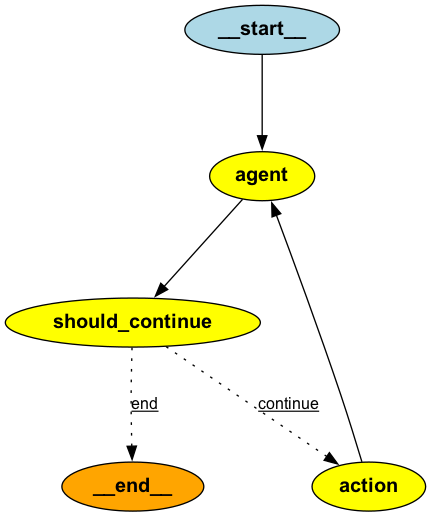

In [156]:
from IPython.display import Image

Image(app.get_graph().draw_png())

## Interacting with the Agent

We can now interact with the agent. Between interactions you can get and update state.


In [118]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "1"}}
for event in app.stream(
    {"messages": [HumanMessage(content="whats the weather in sf?")]}, thread
):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yQrJa8CEOfKBdpVl80jzWf5h', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 94, 'total_tokens': 115}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3764f79e-17b4-4aa3-bbe4-4f92b11ca52c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_yQrJa8CEOfKBdpVl80jzWf5h'}])]}


In [120]:
current_values = app.get_state(thread)
current_values.values

{'messages': [HumanMessage(content='whats the weather in sf?', id='1cfd0c2f-9b60-48da-8938-408fd6aeda13'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yQrJa8CEOfKBdpVl80jzWf5h', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 94, 'total_tokens': 115}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3764f79e-17b4-4aa3-bbe4-4f92b11ca52c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_yQrJa8CEOfKBdpVl80jzWf5h'}])]}

In [122]:
current_values.values["messages"][-1].tool_calls[0]["args"][
    "query"
] = "weather in San Francisco, Accuweather"

In [126]:
app.update_state(thread, current_values.values)

{'configurable': {'thread_id': '1',
  'thread_ts': '2024-04-20T01:13:15.108790+00:00'}}

In [127]:
app.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='whats the weather in sf?', id='1cfd0c2f-9b60-48da-8938-408fd6aeda13'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yQrJa8CEOfKBdpVl80jzWf5h', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 94, 'total_tokens': 115}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3764f79e-17b4-4aa3-bbe4-4f92b11ca52c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco, Accuweather'}, 'id': 'call_yQrJa8CEOfKBdpVl80jzWf5h'}])]}, next=('action',), config={'configurable': {'thread_id': '1', 'thread_ts': '2024-04-20T01:13:15.108790+00:00'}}, parent_config=None)

In [128]:
for event in app.stream(None, thread):
    for v in event.values():
        print(v)

{'messages': [ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1713575495, \'localtime\': \'2024-04-19 18:11\'}, \'current\': {\'last_updated_epoch\': 1713574800, \'last_updated\': \'2024-04-19 18:00\', \'temp_c\': 16.1, \'temp_f\': 61.0, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 16.1, \'wind_kph\': 25.9, \'wind_degree\': 300, \'wind_dir\': \'WNW\', \'pressure_mb\': 1015.0, \'pressure_in\': 29.97, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 67, \'cloud\': 0, \'feelslike_c\': 16.1, \'feelslike_f\': 61.0, \'vis_km\': 16.0, \'vis_miles\': 9.0, \'uv\': 4.0, \'gust_mph\': 20.6, \'gust_kph\': 33.1}}"}]', name='tavily_search_results_json', id='8c7e9af3-65

In [129]:
chkpnt_tuple = memory.get_tuple({"configurable": {"thread_id": "1"}})
config = chkpnt_tuple.config
checkpoint = chkpnt_tuple.checkpoint
metadata = chkpnt_tuple.metadata

# mark as "good"
metadata["score"] = 1
memory.put(config, checkpoint, metadata)

In [130]:
examples = list(memory.search({"score": 1}))

In [131]:
examples

[CheckpointTuple(config={'configurable': {'thread_id': '1', 'thread_ts': '2024-04-20T01:13:36.933600+00:00'}}, checkpoint={'v': 1, 'ts': '2024-04-20T01:13:36.933600+00:00', 'channel_values': {'messages': [HumanMessage(content='whats the weather in sf?', id='1cfd0c2f-9b60-48da-8938-408fd6aeda13'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yQrJa8CEOfKBdpVl80jzWf5h', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 94, 'total_tokens': 115}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3764f79e-17b4-4aa3-bbe4-4f92b11ca52c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco, Accuweather'}, 'id': 'call_yQrJa8CEOfKBdpVl80jzWf5h'}]), ToolMessage(content='[{"url": "https://www.weatherapi

In [157]:
thread = {"configurable": {"thread_id": "7"}}
for event in app.stream(
    {"messages": [HumanMessage(content="whats the weather in la?")]}, thread
):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_amNrYLgitup6hCDiHUYKwodH', 'function': {'arguments': '{"query":"weather in Los Angeles, Accuweather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 296, 'total_tokens': 321}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6b852685-e84f-48e7-b8d0-5b0a44ac9776-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles, Accuweather'}, 'id': 'call_amNrYLgitup6hCDiHUYKwodH'}])]}


In [158]:
for event in app.stream(None, thread):
    for v in event.values():
        print(v)

{'messages': [ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.05, \'lon\': -118.24, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1713576177, \'localtime\': \'2024-04-19 18:22\'}, \'current\': {\'last_updated_epoch\': 1713575700, \'last_updated\': \'2024-04-19 18:15\', \'temp_c\': 17.8, \'temp_f\': 64.0, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/116.png\', \'code\': 1003}, \'wind_mph\': 4.3, \'wind_kph\': 6.8, \'wind_degree\': 250, \'wind_dir\': \'WSW\', \'pressure_mb\': 1014.0, \'pressure_in\': 29.94, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 65, \'cloud\': 50, \'feelslike_c\': 17.8, \'feelslike_f\': 64.0, \'vis_km\': 16.0, \'vis_miles\': 9.0, \'uv\': 5.0, \'gust_mph\': 10.3, \'gust_kph\': 16.6}}"}]', name='tavily_search_results_json', id='6477bd